In [1]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch
import torch.optim as optim
from torch.autograd import Variable

from typing import Callable

2024-03-28 12:56:45.692888: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-28 12:56:45.725394: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 12:56:45.725428: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 12:56:45.726337: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-28 12:56:45.732306: I tensorflow/core/platform/cpu_feature_guar

In [2]:
"""
Here we load the dataset, add gaussian,poisson,speckle

    'gauss'     Gaussian-distributed additive noise.
    'speckle'   Multiplicative noise using out = image + n*image,where
                n is uniform noise with specified mean & variance.
                
We define a function that adds each noise when called from main function
Input & Output: np array
                
"""


def add_noise(img, noise_type="gaussian"):
  
  row, col = 28, 28
  img = img.astype(np.float32)
  
  if noise_type == "gaussian":
    mean  = 0
    var   = 10
    sigma = var**.5
    noise = np.random.normal(-5.9, 5.9, img.shape)
    noise = noise.reshape(row, col)
    img   = img + noise
    return img

  if noise_type == "speckle":
    noise = np.random.randn(row, col)
    noise = noise.reshape(row, col)
    img   = img + img*noise
    return img

In [3]:
mnist_ = mnist.load_data()

train_mask = (mnist_[0][1] == 1) | (mnist_[0][1] == 7)
test_mask = (mnist_[1][1] == 1) | (mnist_[1][1] == 7)

(xtrain, ytrain) = mnist_[0][0][train_mask], mnist_[0][1][train_mask]
(xtest, ytest) = mnist_[1][0][test_mask], mnist_[1][1][test_mask]

In [4]:
print("No of training datapoints:{}\nNo of Test datapoints:{}".format(len(xtrain), len(xtest)))

No of training datapoints:13007
No of Test datapoints:2163


In [5]:
"""
From here onwards,we split the 60k training datapoints into 3 sets each given one type of each noise.
We shuffle them for better generalization.
"""
noises = ["gaussian", "speckle"]
noise_ct = 0
noise_id = 0
traindata = np.zeros((len(xtrain), 28, 28))



for idx in tqdm(range(len(xtrain))):
  if noise_ct < len(xtrain)/2:
    noise_ct += 1
    traindata[idx] = add_noise(xtrain[idx], noise_type=noises[noise_id])
  else:
    print("\n{} noise addition completed to images".format(noises[noise_id]))
    noise_id += 1
    noise_ct = 0


print("\n{} noise addition completed to images".format(noises[noise_id])) 


noise_ct = 0
noise_id = 0
testdata = np.zeros((10000, 28, 28))

for idx in tqdm(range(len(xtest))):
  if noise_ct < len(xtest)/2:
    noise_ct += 1
    x = add_noise(xtest[idx], noise_type=noises[noise_id])
    testdata[idx] = x
    
  else:
    print("\n{} noise addition completed to images".format(noises[noise_id]))
    noise_id += 1
    noise_ct = 0

print("\n{} noise addition completed to images".format(noises[noise_id]))    
  

 24%|██▍       | 3136/13007 [00:00<00:00, 31352.93it/s]


gaussian noise addition completed to images


100%|██████████| 13007/13007 [00:00<00:00, 38111.36it/s]



speckle noise addition completed to images


  0%|          | 0/2163 [00:00<?, ?it/s]


gaussian noise addition completed to images


100%|██████████| 2163/2163 [00:00<00:00, 42249.12it/s]


speckle noise addition completed to images


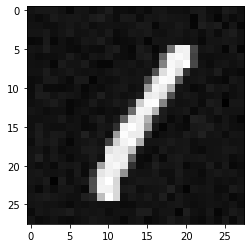

In [6]:
plt.imshow(traindata[0], cmap="gray")

Text(0.5, 1.0, 'Noised Image')

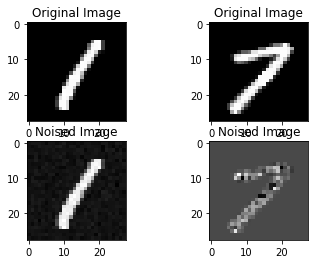

In [7]:
"""
Here we Try to visualize, each type of noise that was introduced in the images
Along with their original versions

"""

f, axes=plt.subplots(2,2)

#showing images with gaussian noise
axes[0,0].imshow(xtrain[0], cmap="gray")
axes[0,0].set_title("Original Image")
axes[1,0].imshow(traindata[0], cmap='gray')
axes[1,0].set_title("Noised Image")

#showing images with speckle noise
axes[0,1].imshow(xtrain[13000], cmap='gray')
axes[0,1].set_title("Original Image")
axes[1,1].imshow(traindata[13000], cmap="gray")
axes[1,1].set_title("Noised Image")

In [8]:
class noisedDataset(Dataset):
  def __init__(self, 
               datasetnoised: np.ndarray, 
               datasetclean: np.ndarray, 
               labels: np.ndarray,
               transform: Callable):
    self.noise = datasetnoised
    self.clean = datasetclean
    self.labels = labels
    self.transform = transform
  
  def __len__(self):
    return len(self.noise)
  
  def __getitem__(self, idx):
    xNoise = self.noise[idx]
    xClean = self.clean[idx]
    y = self.labels[idx]
    
    if self.transform != None:
      xNoise = self.transform(xNoise)
      xClean = self.transform(xClean)

    return (xNoise, xClean, y)
    

In [9]:
tsfms = transforms.Compose([
    transforms.ToTensor()
])

trainset = noisedDataset(traindata, xtrain, ytrain, tsfms)
testset = noisedDataset(testdata, xtest, ytest, tsfms)

In [10]:
trainset.clean[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0, 124, 253, 255,  63,   0,   0,   0,   0,
          0,   0],
       [  

In [11]:
"""
Here , we create the trainloaders and testloaders.
Also, we transform the images using standard lib functions
"""

batch_size = 32

trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader  = DataLoader(testset, batch_size=1, shuffle=True)

In [12]:
"""
Here, we define the autoencoder model.
"""

class denoising_model(nn.Module):
  def __init__(self, latent_size=64, img_size=28*28):
    super(denoising_model,self).__init__()
    self.encoder = nn.Sequential(
      nn.Linear(img_size, 256),
      nn.ReLU(True),
      nn.Linear(256, 128),
      nn.ReLU(True),
      nn.Linear(128, latent_size),
      nn.ReLU(True)
    )
    
    self.decoder = nn.Sequential(
      nn.Linear(latent_size, 128),
      nn.ReLU(True),
      nn.Linear(128, 256),
      nn.ReLU(True),
      nn.Linear(256, img_size),
      nn.Sigmoid()
    )
 
  def forward(self,x):
    x = self.encoder(x)
    x = self.decoder(x)
    
    return x

In [13]:
#We check whether cuda is available and choose device accordingly
if torch.cuda.is_available() == True:
  device = "cuda:0"
else:
  device = "cpu"

In [14]:
model = denoising_model().to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-5)

In [15]:
epochs = 120
l = len(trainloader)
losslist = list()
epochloss = 0
running_loss = 0
for epoch in range(epochs):
  print("Entering Epoch: ", epoch)
  for dirty, clean, label in tqdm((trainloader)):
    
    
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor)
    clean = clean.view(clean.size(0), -1).type(torch.FloatTensor)
    dirty, clean = dirty.to(device), clean.to(device)
    
    #-----------------Forward Pass----------------------
    output = model(dirty)
    loss = criterion(output, clean)

    #-----------------Backward Pass---------------------
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    epochloss += loss.item()
  #-----------------Log-------------------------------
  losslist.append(running_loss/l)
  running_loss = 0
  print("======> epoch: {}/{}, Loss:{}".format(epoch, epochs, loss.item()))
 

Entering Epoch:  0


100%|██████████| 407/407 [00:01<00:00, 274.21it/s]


======> epoch: 0/120, Loss:0.20993363857269287
Entering Epoch:  1


100%|██████████| 407/407 [00:01<00:00, 298.24it/s]


======> epoch: 1/120, Loss:0.06897849589586258
Entering Epoch:  2


100%|██████████| 407/407 [00:01<00:00, 334.51it/s]


======> epoch: 2/120, Loss:0.05960853397846222
Entering Epoch:  3


100%|██████████| 407/407 [00:01<00:00, 292.53it/s]


======> epoch: 3/120, Loss:0.05839918926358223
Entering Epoch:  4


100%|██████████| 407/407 [00:01<00:00, 353.01it/s]


======> epoch: 4/120, Loss:0.050664421170949936
Entering Epoch:  5


100%|██████████| 407/407 [00:01<00:00, 301.93it/s]


======> epoch: 5/120, Loss:0.05293458327651024
Entering Epoch:  6


100%|██████████| 407/407 [00:01<00:00, 295.17it/s]


======> epoch: 6/120, Loss:0.04146331548690796
Entering Epoch:  7


100%|██████████| 407/407 [00:01<00:00, 334.47it/s]


======> epoch: 7/120, Loss:0.044664643704891205
Entering Epoch:  8


100%|██████████| 407/407 [00:01<00:00, 298.26it/s]


======> epoch: 8/120, Loss:0.039750415831804276
Entering Epoch:  9


100%|██████████| 407/407 [00:01<00:00, 297.42it/s]


======> epoch: 9/120, Loss:0.04541091248393059
Entering Epoch:  10


100%|██████████| 407/407 [00:01<00:00, 304.13it/s]


======> epoch: 10/120, Loss:0.0423651821911335
Entering Epoch:  11


100%|██████████| 407/407 [00:01<00:00, 311.36it/s]


======> epoch: 11/120, Loss:0.036977000534534454
Entering Epoch:  12


100%|██████████| 407/407 [00:01<00:00, 334.61it/s]


======> epoch: 12/120, Loss:0.03881702572107315
Entering Epoch:  13


100%|██████████| 407/407 [00:01<00:00, 254.92it/s]


======> epoch: 13/120, Loss:0.03513846546411514
Entering Epoch:  14


100%|██████████| 407/407 [00:01<00:00, 276.55it/s]


======> epoch: 14/120, Loss:0.03329654037952423
Entering Epoch:  15


100%|██████████| 407/407 [00:01<00:00, 281.65it/s]


======> epoch: 15/120, Loss:0.03777202591300011
Entering Epoch:  16


100%|██████████| 407/407 [00:01<00:00, 249.31it/s]


======> epoch: 16/120, Loss:0.026845142245292664
Entering Epoch:  17


100%|██████████| 407/407 [00:01<00:00, 278.81it/s]


======> epoch: 17/120, Loss:0.03043084219098091
Entering Epoch:  18


100%|██████████| 407/407 [00:01<00:00, 269.02it/s]


======> epoch: 18/120, Loss:0.033978551626205444
Entering Epoch:  19


100%|██████████| 407/407 [00:01<00:00, 248.34it/s]


======> epoch: 19/120, Loss:0.03314061462879181
Entering Epoch:  20


100%|██████████| 407/407 [00:01<00:00, 253.81it/s]


======> epoch: 20/120, Loss:0.032742030918598175
Entering Epoch:  21


100%|██████████| 407/407 [00:01<00:00, 248.79it/s]


======> epoch: 21/120, Loss:0.03543565049767494
Entering Epoch:  22


100%|██████████| 407/407 [00:01<00:00, 260.66it/s]


======> epoch: 22/120, Loss:0.032208334654569626
Entering Epoch:  23


100%|██████████| 407/407 [00:01<00:00, 267.64it/s]


======> epoch: 23/120, Loss:0.032716765999794006
Entering Epoch:  24


100%|██████████| 407/407 [00:01<00:00, 244.54it/s]


======> epoch: 24/120, Loss:0.035901907831430435
Entering Epoch:  25


100%|██████████| 407/407 [00:01<00:00, 243.85it/s]


======> epoch: 25/120, Loss:0.03522283211350441
Entering Epoch:  26


100%|██████████| 407/407 [00:01<00:00, 213.50it/s]


======> epoch: 26/120, Loss:0.028285186737775803
Entering Epoch:  27


100%|██████████| 407/407 [00:02<00:00, 155.41it/s]


======> epoch: 27/120, Loss:0.02737642079591751
Entering Epoch:  28


100%|██████████| 407/407 [00:02<00:00, 200.01it/s]


======> epoch: 28/120, Loss:0.025044459849596024
Entering Epoch:  29


100%|██████████| 407/407 [00:01<00:00, 246.92it/s]


======> epoch: 29/120, Loss:0.02984771691262722
Entering Epoch:  30


100%|██████████| 407/407 [00:01<00:00, 231.11it/s]


======> epoch: 30/120, Loss:0.03736429661512375
Entering Epoch:  31


100%|██████████| 407/407 [00:01<00:00, 254.99it/s]


======> epoch: 31/120, Loss:0.03417259082198143
Entering Epoch:  32


100%|██████████| 407/407 [00:01<00:00, 218.90it/s]


======> epoch: 32/120, Loss:0.028401656076312065
Entering Epoch:  33


100%|██████████| 407/407 [00:01<00:00, 234.37it/s]


======> epoch: 33/120, Loss:0.027264168485999107
Entering Epoch:  34


100%|██████████| 407/407 [00:01<00:00, 245.52it/s]


======> epoch: 34/120, Loss:0.034679289907217026
Entering Epoch:  35


100%|██████████| 407/407 [00:01<00:00, 216.52it/s]


======> epoch: 35/120, Loss:0.03341257944703102
Entering Epoch:  36


100%|██████████| 407/407 [00:01<00:00, 231.30it/s]


======> epoch: 36/120, Loss:0.038631752133369446
Entering Epoch:  37


100%|██████████| 407/407 [00:01<00:00, 247.78it/s]


======> epoch: 37/120, Loss:0.03096666745841503
Entering Epoch:  38


100%|██████████| 407/407 [00:01<00:00, 247.87it/s]


======> epoch: 38/120, Loss:0.03671441227197647
Entering Epoch:  39


100%|██████████| 407/407 [00:01<00:00, 233.33it/s]


======> epoch: 39/120, Loss:0.0264167208224535
Entering Epoch:  40


100%|██████████| 407/407 [00:01<00:00, 229.12it/s]


======> epoch: 40/120, Loss:0.028618592768907547
Entering Epoch:  41


100%|██████████| 407/407 [00:01<00:00, 251.60it/s]


======> epoch: 41/120, Loss:0.03879966959357262
Entering Epoch:  42


100%|██████████| 407/407 [00:01<00:00, 243.32it/s]


======> epoch: 42/120, Loss:0.0339028537273407
Entering Epoch:  43


100%|██████████| 407/407 [00:01<00:00, 246.74it/s]


======> epoch: 43/120, Loss:0.029089275747537613
Entering Epoch:  44


100%|██████████| 407/407 [00:01<00:00, 247.58it/s]


======> epoch: 44/120, Loss:0.030182762071490288
Entering Epoch:  45


100%|██████████| 407/407 [00:01<00:00, 250.61it/s]


======> epoch: 45/120, Loss:0.04990694671869278
Entering Epoch:  46


100%|██████████| 407/407 [00:01<00:00, 245.95it/s]


======> epoch: 46/120, Loss:0.031174203380942345
Entering Epoch:  47


100%|██████████| 407/407 [00:01<00:00, 248.91it/s]


======> epoch: 47/120, Loss:0.03389958664774895
Entering Epoch:  48


100%|██████████| 407/407 [00:01<00:00, 241.59it/s]


======> epoch: 48/120, Loss:0.03246009722352028
Entering Epoch:  49


100%|██████████| 407/407 [00:01<00:00, 232.30it/s]


======> epoch: 49/120, Loss:0.028547253459692
Entering Epoch:  50


100%|██████████| 407/407 [00:01<00:00, 235.01it/s]


======> epoch: 50/120, Loss:0.0369926355779171
Entering Epoch:  51


100%|██████████| 407/407 [00:01<00:00, 227.46it/s]


======> epoch: 51/120, Loss:0.02680124342441559
Entering Epoch:  52


100%|██████████| 407/407 [00:01<00:00, 242.64it/s]


======> epoch: 52/120, Loss:0.03791887313127518
Entering Epoch:  53


100%|██████████| 407/407 [00:01<00:00, 250.56it/s]


======> epoch: 53/120, Loss:0.02690281718969345
Entering Epoch:  54


100%|██████████| 407/407 [00:01<00:00, 239.03it/s]


======> epoch: 54/120, Loss:0.027417168021202087
Entering Epoch:  55


100%|██████████| 407/407 [00:01<00:00, 230.52it/s]


======> epoch: 55/120, Loss:0.030495377257466316
Entering Epoch:  56


100%|██████████| 407/407 [00:01<00:00, 249.97it/s]


======> epoch: 56/120, Loss:0.03223402053117752
Entering Epoch:  57


100%|██████████| 407/407 [00:01<00:00, 249.38it/s]


======> epoch: 57/120, Loss:0.026564856991171837
Entering Epoch:  58


100%|██████████| 407/407 [00:01<00:00, 235.97it/s]


======> epoch: 58/120, Loss:0.03590485081076622
Entering Epoch:  59


100%|██████████| 407/407 [00:01<00:00, 227.88it/s]


======> epoch: 59/120, Loss:0.029173122718930244
Entering Epoch:  60


100%|██████████| 407/407 [00:01<00:00, 240.48it/s]


======> epoch: 60/120, Loss:0.024891093373298645
Entering Epoch:  61


100%|██████████| 407/407 [00:01<00:00, 236.83it/s]


======> epoch: 61/120, Loss:0.025793258100748062
Entering Epoch:  62


100%|██████████| 407/407 [00:01<00:00, 238.81it/s]


======> epoch: 62/120, Loss:0.023951202630996704
Entering Epoch:  63


100%|██████████| 407/407 [00:01<00:00, 245.16it/s]


======> epoch: 63/120, Loss:0.0367775484919548
Entering Epoch:  64


100%|██████████| 407/407 [00:01<00:00, 234.59it/s]


======> epoch: 64/120, Loss:0.03178754448890686
Entering Epoch:  65


100%|██████████| 407/407 [00:01<00:00, 230.63it/s]


======> epoch: 65/120, Loss:0.032329708337783813
Entering Epoch:  66


100%|██████████| 407/407 [00:01<00:00, 236.60it/s]


======> epoch: 66/120, Loss:0.025774914771318436
Entering Epoch:  67


100%|██████████| 407/407 [00:01<00:00, 226.36it/s]


======> epoch: 67/120, Loss:0.026386208832263947
Entering Epoch:  68


100%|██████████| 407/407 [00:01<00:00, 250.67it/s]


======> epoch: 68/120, Loss:0.02790784277021885
Entering Epoch:  69


100%|██████████| 407/407 [00:01<00:00, 235.10it/s]


======> epoch: 69/120, Loss:0.03712892159819603
Entering Epoch:  70


100%|██████████| 407/407 [00:01<00:00, 228.14it/s]


======> epoch: 70/120, Loss:0.025939850136637688
Entering Epoch:  71


100%|██████████| 407/407 [00:01<00:00, 257.45it/s]


======> epoch: 71/120, Loss:0.034650854766368866
Entering Epoch:  72


100%|██████████| 407/407 [00:01<00:00, 233.13it/s]


======> epoch: 72/120, Loss:0.024258611723780632
Entering Epoch:  73


100%|██████████| 407/407 [00:01<00:00, 238.53it/s]


======> epoch: 73/120, Loss:0.023010479286313057
Entering Epoch:  74


100%|██████████| 407/407 [00:01<00:00, 239.01it/s]


======> epoch: 74/120, Loss:0.02111784741282463
Entering Epoch:  75


100%|██████████| 407/407 [00:01<00:00, 233.84it/s]


======> epoch: 75/120, Loss:0.023661093786358833
Entering Epoch:  76


100%|██████████| 407/407 [00:01<00:00, 229.54it/s]


======> epoch: 76/120, Loss:0.025254499167203903
Entering Epoch:  77


100%|██████████| 407/407 [00:01<00:00, 238.27it/s]


======> epoch: 77/120, Loss:0.026348425075411797
Entering Epoch:  78


100%|██████████| 407/407 [00:01<00:00, 242.50it/s]


======> epoch: 78/120, Loss:0.03175109252333641
Entering Epoch:  79


100%|██████████| 407/407 [00:01<00:00, 237.22it/s]


======> epoch: 79/120, Loss:0.036574043333530426
Entering Epoch:  80


100%|██████████| 407/407 [00:01<00:00, 238.43it/s]


======> epoch: 80/120, Loss:0.03090130351483822
Entering Epoch:  81


100%|██████████| 407/407 [00:01<00:00, 228.76it/s]


======> epoch: 81/120, Loss:0.02839715965092182
Entering Epoch:  82


100%|██████████| 407/407 [00:01<00:00, 233.77it/s]


======> epoch: 82/120, Loss:0.026722686365246773
Entering Epoch:  83


100%|██████████| 407/407 [00:01<00:00, 228.89it/s]


======> epoch: 83/120, Loss:0.028743471950292587
Entering Epoch:  84


100%|██████████| 407/407 [00:01<00:00, 235.90it/s]


======> epoch: 84/120, Loss:0.02137073501944542
Entering Epoch:  85


100%|██████████| 407/407 [00:01<00:00, 240.81it/s]


======> epoch: 85/120, Loss:0.02549172192811966
Entering Epoch:  86


100%|██████████| 407/407 [00:01<00:00, 229.56it/s]


======> epoch: 86/120, Loss:0.023506369441747665
Entering Epoch:  87


100%|██████████| 407/407 [00:01<00:00, 240.21it/s]


======> epoch: 87/120, Loss:0.02179926447570324
Entering Epoch:  88


100%|██████████| 407/407 [00:01<00:00, 223.29it/s]


======> epoch: 88/120, Loss:0.02631712332367897
Entering Epoch:  89


100%|██████████| 407/407 [00:01<00:00, 223.51it/s]


======> epoch: 89/120, Loss:0.024820618331432343
Entering Epoch:  90


100%|██████████| 407/407 [00:01<00:00, 243.68it/s]


======> epoch: 90/120, Loss:0.026512885466217995
Entering Epoch:  91


100%|██████████| 407/407 [00:01<00:00, 225.66it/s]


======> epoch: 91/120, Loss:0.01776980236172676
Entering Epoch:  92


100%|██████████| 407/407 [00:02<00:00, 177.31it/s]


======> epoch: 92/120, Loss:0.026356883347034454
Entering Epoch:  93


100%|██████████| 407/407 [00:01<00:00, 205.44it/s]


======> epoch: 93/120, Loss:0.025875329971313477
Entering Epoch:  94


100%|██████████| 407/407 [00:01<00:00, 234.31it/s]


======> epoch: 94/120, Loss:0.030035123229026794
Entering Epoch:  95


100%|██████████| 407/407 [00:01<00:00, 250.98it/s]


======> epoch: 95/120, Loss:0.024647068232297897
Entering Epoch:  96


100%|██████████| 407/407 [00:01<00:00, 228.12it/s]


======> epoch: 96/120, Loss:0.03457965329289436
Entering Epoch:  97


100%|██████████| 407/407 [00:01<00:00, 245.22it/s]


======> epoch: 97/120, Loss:0.01745973341166973
Entering Epoch:  98


100%|██████████| 407/407 [00:01<00:00, 239.13it/s]


======> epoch: 98/120, Loss:0.03256642445921898
Entering Epoch:  99


100%|██████████| 407/407 [00:01<00:00, 235.86it/s]


======> epoch: 99/120, Loss:0.02056143432855606
Entering Epoch:  100


100%|██████████| 407/407 [00:01<00:00, 242.17it/s]


======> epoch: 100/120, Loss:0.024621540680527687
Entering Epoch:  101


100%|██████████| 407/407 [00:01<00:00, 232.74it/s]


======> epoch: 101/120, Loss:0.029382850974798203
Entering Epoch:  102


100%|██████████| 407/407 [00:01<00:00, 234.54it/s]


======> epoch: 102/120, Loss:0.02255948632955551
Entering Epoch:  103


100%|██████████| 407/407 [00:01<00:00, 241.40it/s]


======> epoch: 103/120, Loss:0.02000744827091694
Entering Epoch:  104


100%|██████████| 407/407 [00:01<00:00, 235.53it/s]


======> epoch: 104/120, Loss:0.023371810093522072
Entering Epoch:  105


100%|██████████| 407/407 [00:01<00:00, 245.08it/s]


======> epoch: 105/120, Loss:0.026846930384635925
Entering Epoch:  106


100%|██████████| 407/407 [00:01<00:00, 250.72it/s]


======> epoch: 106/120, Loss:0.022013038396835327
Entering Epoch:  107


100%|██████████| 407/407 [00:01<00:00, 225.41it/s]


======> epoch: 107/120, Loss:0.023497385904192924
Entering Epoch:  108


100%|██████████| 407/407 [00:01<00:00, 254.88it/s]


======> epoch: 108/120, Loss:0.031726524233818054
Entering Epoch:  109


100%|██████████| 407/407 [00:01<00:00, 228.11it/s]


======> epoch: 109/120, Loss:0.030348090454936028
Entering Epoch:  110


100%|██████████| 407/407 [00:02<00:00, 199.46it/s]


======> epoch: 110/120, Loss:0.025615746155381203
Entering Epoch:  111


100%|██████████| 407/407 [00:01<00:00, 245.77it/s]


======> epoch: 111/120, Loss:0.019609548151493073
Entering Epoch:  112


100%|██████████| 407/407 [00:01<00:00, 242.26it/s]


======> epoch: 112/120, Loss:0.021238641813397408
Entering Epoch:  113


100%|██████████| 407/407 [00:01<00:00, 231.56it/s]


======> epoch: 113/120, Loss:0.02578524872660637
Entering Epoch:  114


100%|██████████| 407/407 [00:02<00:00, 190.82it/s]


======> epoch: 114/120, Loss:0.023781977593898773
Entering Epoch:  115


100%|██████████| 407/407 [00:01<00:00, 236.49it/s]


======> epoch: 115/120, Loss:0.026331990957260132
Entering Epoch:  116


100%|██████████| 407/407 [00:01<00:00, 227.08it/s]


======> epoch: 116/120, Loss:0.0298768263310194
Entering Epoch:  117


100%|██████████| 407/407 [00:01<00:00, 242.07it/s]


======> epoch: 117/120, Loss:0.021871419623494148
Entering Epoch:  118


100%|██████████| 407/407 [00:01<00:00, 210.70it/s]


======> epoch: 118/120, Loss:0.02609056793153286
Entering Epoch:  119


100%|██████████| 407/407 [00:01<00:00, 232.70it/s]

======> epoch: 119/120, Loss:0.023405563086271286


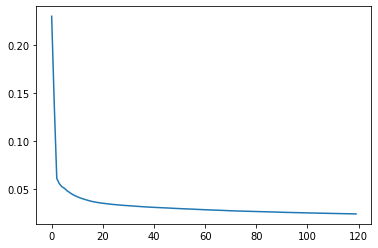

In [16]:
plt.plot(range(len(losslist)),losslist)

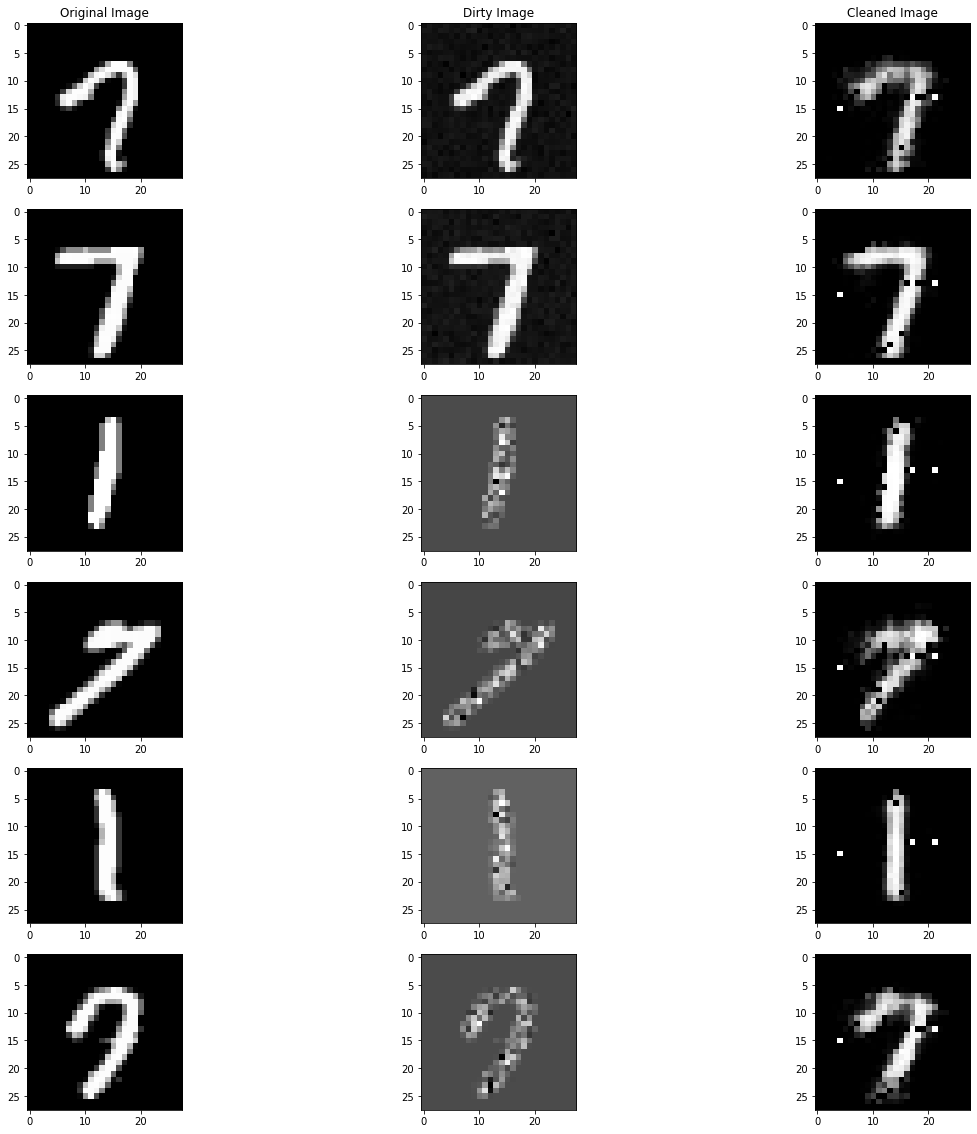

In [18]:
"""Here, we try to visualize some of the results.
  We randomly generate 6 numbers in between 1 and 10k , run them through the model,
  and show the results with comparisons
 """
f,axes= plt.subplots(6,3,figsize=(20,20))
axes[0,0].set_title("Original Image")
axes[0,1].set_title("Dirty Image")
axes[0,2].set_title("Cleaned Image")

test_imgs=np.random.randint(0,len(xtest),size=6)
for idx in range((6)):
  dirty=testset[test_imgs[idx]][0]
  clean=testset[test_imgs[idx]][1]
  label=testset[test_imgs[idx]][2]
  dirty=dirty.view(dirty.size(0),-1).type(torch.FloatTensor)
  dirty=dirty.to(device)
  output=model(dirty)
  
  output=output.view(1,28,28)
  output=output.permute(1,2,0).squeeze(2)
  output=output.detach().cpu().numpy()
  
  dirty=dirty.view(1,28,28)
  dirty=dirty.permute(1,2,0).squeeze(2)
  dirty=dirty.detach().cpu().numpy()
  
  clean=clean.permute(1,2,0).squeeze(2)
  clean=clean.detach().cpu().numpy()
  
  axes[idx,0].imshow(clean,cmap="gray")
  axes[idx,1].imshow(dirty,cmap="gray")
  axes[idx,2].imshow(output,cmap="gray")

In [19]:
PATH = "model"
torch.save(model.state_dict(), PATH)  # We save the model state dict at PATH   